## Import libraries

In [26]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
## Add libraries for SMOTE


## Read dataset

In [27]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v100.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_24.0,wake_day_part_25.0,wake_day_part_26.0,wake_day_part_27.0,wake_day_part_28.0,wake_day_part_29.0,wake_day_part_30.0,wake_day_part_31.0,wake_day_part_32.0,wake_day_part_33.0
0,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.187031,...,0,0,0,0,0,0,0,0,0,0
1,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.180555,...,0,0,0,0,0,0,0,0,0,0
2,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.176050,...,0,0,0,0,0,0,0,0,0,0
3,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.172060,...,0,0,0,0,0,0,0,0,0,0
4,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.104721,...,0,0,0,0,0,0,0,0,0,0


In [28]:
## Inspect the number of unique participant_ids
num_participants = raw_feature_df_scaled['participant_id'].nunique()
print(f"Number of unique participants: {num_participants}")

## Check the shape of the dataset
num_rows, num_cols = raw_feature_df_scaled.shape
print(f"Dataset shape: {num_rows} rows, {num_cols} columns")

Number of unique participants: 100
Dataset shape: 1087353 rows, 62 columns


### Impute missing data
Impute with median [SKIP THIS STEP]

In [43]:
def impute_missing_with_median(df):
    """
    Impute missing values in all columns of a DataFrame using the median strategy within each participant_id group, except for 'participant_id' and 'outcome'.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    skip_cols = ['participant_id', 'outcome']
    cols_to_impute = [col for col in df.columns if col not in skip_cols]
    df_result = df.copy()
    global_medians = df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group[cols_to_impute].median()
        # Where group median is nan (all missing), fallback to global median
        fill_values = group_medians.fillna(global_medians)
        return group[cols_to_impute].fillna(fill_values)
    df_result[cols_to_impute] = df.groupby('participant_id', group_keys=False).apply(impute_group)
    return df_result

# Example usage:
raw_feature_df_scaled = impute_missing_with_median(raw_feature_df_scaled)

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20162/1467341710.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = df.groupby('participant_id', group_keys=False).apply(impute_group)


In [44]:
# Print the percentage of missing values for each column in raw_feature_df_scaled
missing_pct = raw_feature_df_scaled.isnull().mean() * 100
print("% Missing values per column:")
print(missing_pct.sort_values(ascending=False))

% Missing values per column:
participant_id               0.0
wake_day_part_18.0           0.0
wake_day_part_5.0            0.0
wake_day_part_6.0            0.0
wake_day_part_7.0            0.0
wake_day_part_8.0            0.0
wake_day_part_9.0            0.0
wake_day_part_10.0           0.0
wake_day_part_11.0           0.0
wake_day_part_12.0           0.0
wake_day_part_13.0           0.0
wake_day_part_15.0           0.0
wake_day_part_16.0           0.0
wake_day_part_17.0           0.0
wake_day_part_19.0           0.0
wake_day_part_3.0            0.0
wake_day_part_20.0           0.0
wake_day_part_22.0           0.0
wake_day_part_23.0           0.0
wake_day_part_24.0           0.0
wake_day_part_25.0           0.0
wake_day_part_26.0           0.0
wake_day_part_27.0           0.0
wake_day_part_28.0           0.0
wake_day_part_29.0           0.0
wake_day_part_30.0           0.0
wake_day_part_31.0           0.0
wake_day_part_32.0           0.0
wake_day_part_4.0            0.0
wake_day_part_

## Split training and test data
First 90% data from each user as part of training. Then the remaining 10% for testing from all users.

In [29]:
def split_train_test_by_participant(df, id_col='participant_id', train_frac=0.1):
    """
    Splits the DataFrame into training and testing sets for each participant.
    The first train_frac (default 80%) of each participant's data goes to train, the rest to test.
    Returns: train_df, test_df
    """
    train_list = []
    test_list = []
    for pid, group in df.groupby(id_col):
        n = len(group)
        split_idx = int(np.floor(train_frac * n))
        group_sorted = group.sort_index()  # keep original order
        train_list.append(group_sorted.iloc[:split_idx])
        test_list.append(group_sorted.iloc[split_idx:])
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

# Apply the function to split the dataset
train_df, test_df = split_train_test_by_participant(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (108685, 62)
Test set shape: (978668, 62)


### Verify training distribution

In [30]:
def participant_split_summary(train_df, test_df, id_col='participant_id'):
    """
    Returns a DataFrame with columns: participant_id, n_train, n_test, pct_train, pct_test
    """
    train_counts = train_df.groupby(id_col).size().rename('n_train')
    test_counts = test_df.groupby(id_col).size().rename('n_test')
    summary = pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)
    summary['total'] = summary['n_train'] + summary['n_test']
    summary['pct_train'] = (summary['n_train'] / summary['total'] * 100).round(2)
    summary['pct_test'] = (summary['n_test'] / summary['total'] * 100).round(2)
    summary = summary.reset_index()[[id_col, 'n_train', 'n_test', 'pct_train', 'pct_test']]
    return summary

# Example usage:
split_summary = participant_split_summary(train_df, test_df)
split_summary

,participant_id,n_train,n_test,pct_train,pct_test
0,arrivejanitoruniformly@timestudy_com,1084,9761,10.00,90.00
1,atlanticchefhatchet@timestudy_com,1323,11915,9.99,90.01
2,badlandwiltmuseum@timestudy_com,1225,11032,9.99,90.01
3,bannisterhardwiredladle@timestudy_com,1275,11482,9.99,90.01
4,bartenderradiatorapplied@timestudy_com,469,4223,10.00,90.00
...,...,...,...,...,...
95,vagabondnumerousflatterer@timestudy_com,1096,9868,10.00,90.00
96,whoeverrelightspookily@timestudy_com,836,7524,10.00,90.00
97,wikipediaetchingcrystal@timestudy_com,1289,11610,9.99,90.01
98,wrigglecatalyststerility@timestudy_com,1245,11211,10.00,90.00


## Impute missing data in training

In [31]:
def impute_training_with_median(train_df, id_col='participant_id', outcome_col='outcome'):
    """
    Impute missing values in all feature columns of train_df using the median within each participant_id group.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    import pandas as pd
    skip_cols = [id_col, outcome_col]
    cols_to_impute = [col for col in train_df.columns if col not in skip_cols]
    df_result = train_df.copy()
    global_medians = train_df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group[cols_to_impute].median()
        fill_values = group_medians.fillna(global_medians)
        return group[cols_to_impute].fillna(fill_values)
    df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)
    return df_result

# Example usage:
train_df = impute_training_with_median(train_df)

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30652/597708625.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)


## Apply SMOTE to training data

In [32]:
# Apply SMOTE to the training data to address class imbalance (assumes missing values already imputed)
from imblearn.over_sampling import SMOTE
feature_cols = [col for col in train_df.columns if col not in ['outcome', 'participant_id']]
X_train = train_df[feature_cols]
y_train = train_df['outcome']
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Convert back to DataFrame with feature names to avoid warning
X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_cols)
print('Original training set class distribution:')
print(y_train.value_counts())
print('Resampled training set class distribution:')
print(pd.Series(y_train_resampled).value_counts())

Original training set class distribution:
outcome
1    85761
0    22924
Name: count, dtype: int64
Resampled training set class distribution:
outcome
1    85761
0    85761
Name: count, dtype: int64


## Train a RandomForest classifier
To predict the next 20% of the dfata per user

In [11]:
def train_random_forest_classifier(X, y, random_state=42):
    """
    Trains a RandomForestClassifier on the provided features and labels.
    Uses class_weight='balanced' to handle class imbalance.
    Returns the trained model.
    """
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=10,
        max_features='sqrt',
        n_estimators=100,
        random_state=random_state
    )
    clf.fit(X, y)
    return clf

# Example usage:
rf_model = train_random_forest_classifier(X_train_resampled, y_train_resampled)

## Test on the test data

In [13]:
def evaluate_classifier_on_test(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluates the classifier on test_df and prints accuracy, precision, recall, F1, and AUC.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}' if auc is not None else 'AUC: Not available')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Example usage:
results = evaluate_classifier_on_test(rf_model, test_df)

Accuracy: 0.7692
Precision: 0.9067
Recall: 0.7908
F1 Score: 0.8448
AUC: 0.8104


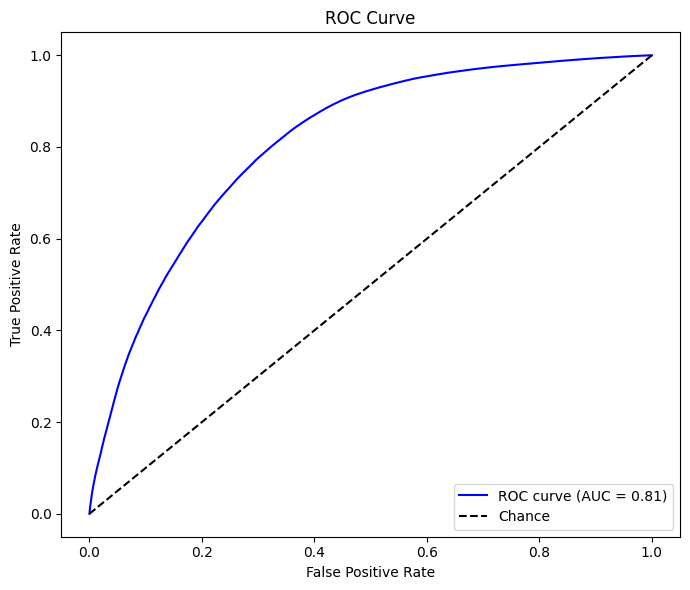

AUC: 0.8104


In [14]:
def plot_roc_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the ROC curve for the model on test_df and prints the AUC.
    """
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f'AUC: {auc:.4f}')

# Example usage:
plot_roc_curve(rf_model, test_df)

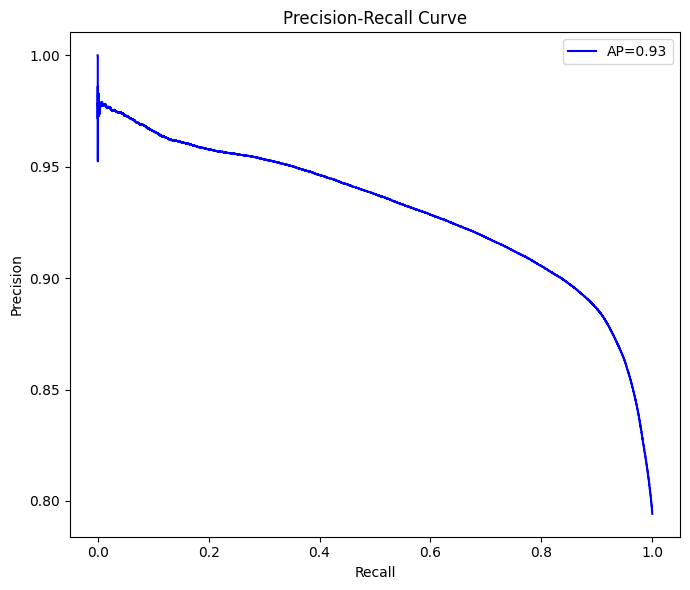

Average Precision Score: 0.9303


In [15]:
def plot_precision_recall_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the Precision-Recall curve for the model on test_df and prints the average precision score.
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='b', label=f'AP={avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    print(f'Average Precision Score: {avg_precision:.4f}')

# Example usage:
plot_precision_recall_curve(rf_model, test_df)

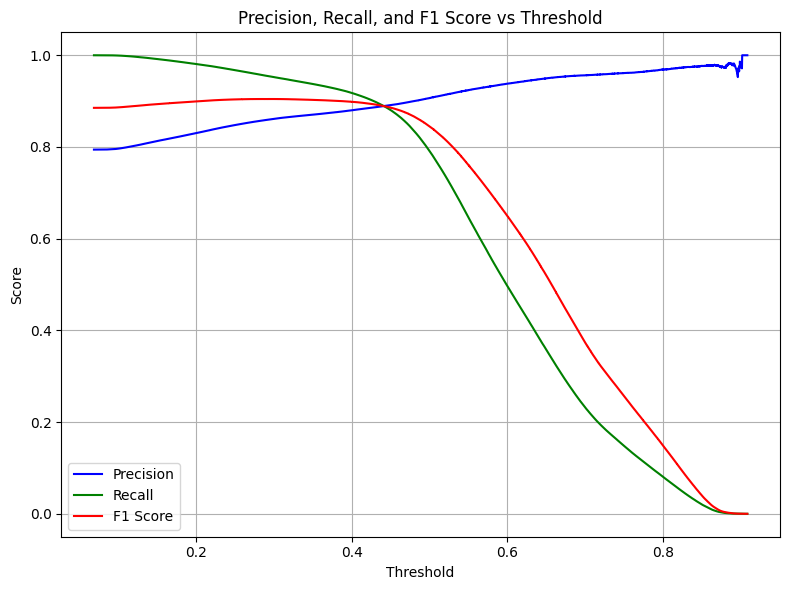

In [16]:
def plot_precision_recall_f1_vs_threshold(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots precision, recall, and F1 score as functions of the decision threshold for the model on test_df.
    """
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], label='Precision', color='b')
    plt.plot(thresholds, recall[:-1], label='Recall', color='g')
    plt.plot(thresholds, f1[:-1], label='F1 Score', color='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_precision_recall_f1_vs_threshold(rf_model, test_df)

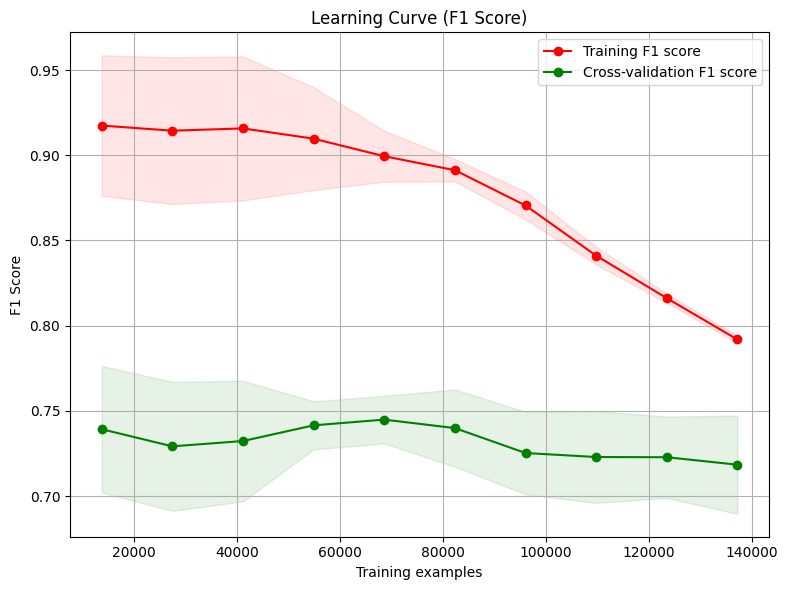

In [53]:
def plot_learning_curve(model, X, y, cv=5, scoring='f1', train_sizes=None, random_state=42):
    """
    Plots the learning curve for the given model and data using F1 as the scoring metric for both training and cross-validation.
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    import matplotlib.pyplot as plt
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, random_state=random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training F1 score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation F1 score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.title('Learning Curve (F1 Score)')
    plt.xlabel('Training examples')
    plt.ylabel('F1 Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_learning_curve(rf_model, X_train_resampled, y_train_resampled)

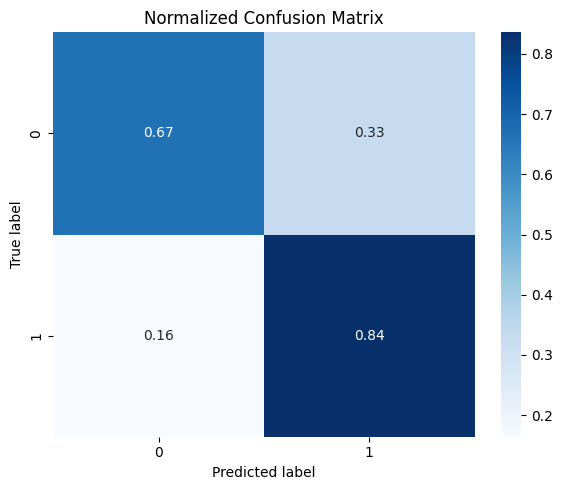

In [54]:
def plot_normalized_confusion_matrix(model, test_df, outcome_col='outcome', id_col='participant_id', cmap='Blues'):
    """
    Plots the normalized confusion matrix for the model on test_df.
    """
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_normalized_confusion_matrix(rf_model, test_df)

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'n_estimators': [100, 200],
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit grid search on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Use the best estimator for further evaluation
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Python(32429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32434) Malloc

KeyboardInterrupt: 

In [18]:
def train_best_random_forest(X, y, best_params, random_state=42):
    """
    Trains a RandomForestClassifier using the best parameters from grid search.
    Returns the trained model.
    """
    from sklearn.ensemble import RandomForestClassifier
    # Ensure random_state and class_weight are set for reproducibility and balance
    params = best_params.copy()
    params['random_state'] = random_state
    params['class_weight'] = 'balanced'
    clf = RandomForestClassifier(**params)
    clf.fit(X, y)
    return clf

# Example usage:
best_rf_model_manual = train_best_random_forest(X_train_resampled, y_train_resampled, grid_search.best_params_)

In [19]:
# Evaluate the new model trained with best parameters on the test set
results_best_manual = evaluate_classifier_on_test(best_rf_model_manual, test_df)

Accuracy: 0.8175
Precision: 0.9229
Recall: 0.8618
F1 Score: 0.8913
AUC: 0.7993


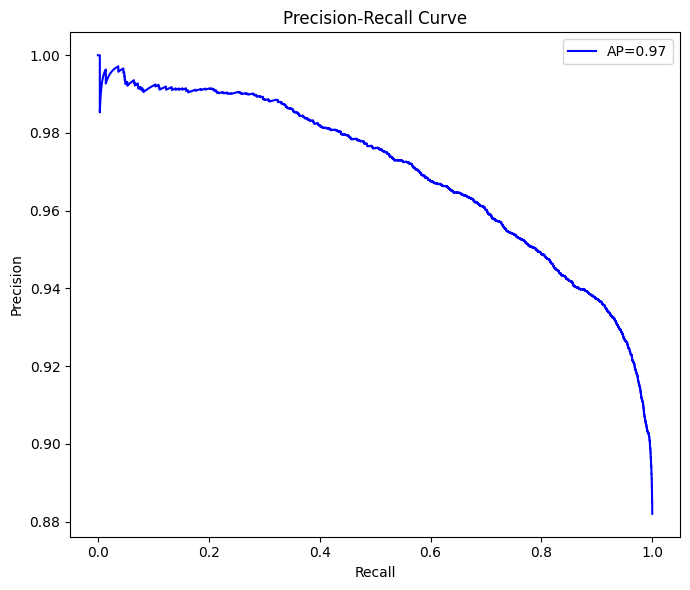

Average Precision Score: 0.9697


In [103]:
# Plot the precision-recall curve for the new model
plot_precision_recall_curve(best_rf_model_manual, test_df)

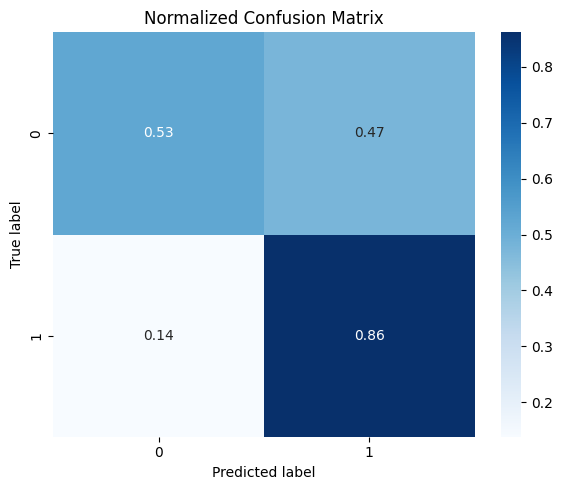

In [20]:
# Plot the normalized confusion matrix for the new model
plot_normalized_confusion_matrix(best_rf_model_manual, test_df)

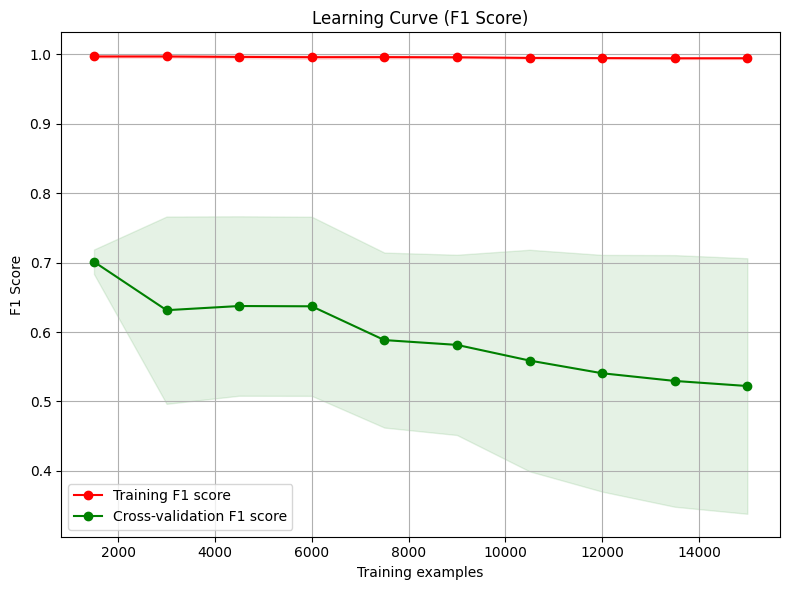

In [21]:
# Plot the learning curve for the new model using F1 as the training score
plot_learning_curve(best_rf_model_manual, X_train_resampled, y_train_resampled)

                      feature  importance
9                   mims_5min    0.356241
2             charging_status    0.186401
11             completion_24h    0.074665
16     completion_since_start    0.058211
15      completion_since_wake    0.055967
4              dist_from_home    0.044384
12              completion_1h    0.034855
10              days_in_study    0.032140
6            last_phone_usage    0.028932
13       time_between_prompts    0.019885
7     closeness_to_sleep_time    0.016879
8      closeness_to_wake_time    0.016667
14   time_since_last_answered    0.016441
28          wake_day_part_0.0    0.008261
3                   screen_on    0.005286
5             is_phone_locked    0.005183
1       in_battery_saver_mode    0.004660
26  location_category_Transit    0.004032
23     location_category_Home    0.003975
27     location_category_Work    0.003706
18  time_of_day_Early Morning    0.003226
24    location_category_Other    0.003040
0                  is_weekend    0

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30652/1135274175.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


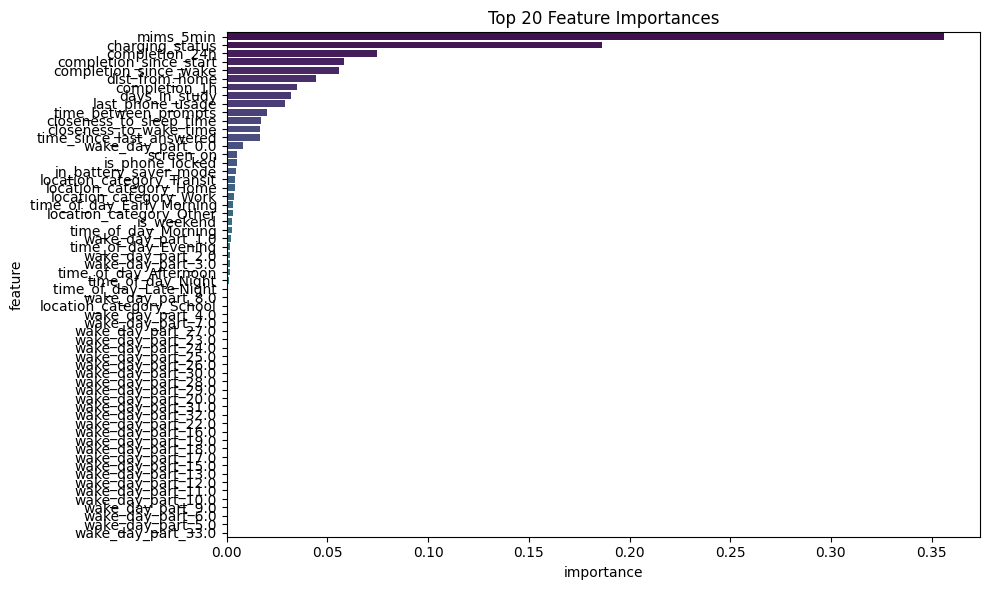

In [17]:
# Check which features are contributing most to the new model
importances = rf_model.feature_importances_
feature_names = X_train_resampled.columns if hasattr(X_train_resampled, 'columns') else [f'feature_{i}' for i in range(len(importances))]
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Optional: Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [20]:
def leave_one_participant_out_cv_rf_smote(raw_feature_df_scaled, label_col='outcome', group_col='participant_id', window_frac=0.1, random_state=42):
    """
    Performs leave-one-participant-out cross-validation.
    For each fold:
      - Leave one participant out as hold-out test set.
      - For remaining participants, use their first window_frac (default 10%) of data as training, rest as test.
      - Impute missing values in training data using median per participant, apply SMOTE per participant_id, train RandomForest (balanced).
      - Test only on the held-out participant.
    Returns arrays of F1 scores, mean and std of F1.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score
    from imblearn.over_sampling import SMOTE
    import numpy as np
    import pandas as pd

    def impute_training_with_median(train_df, id_col='participant_id', outcome_col='outcome'):
        skip_cols = [id_col, outcome_col]
        cols_to_impute = [col for col in train_df.columns if col not in skip_cols]
        df_result = train_df.copy()
        global_medians = train_df[cols_to_impute].median()
        def impute_group(group):
            group_medians = group[cols_to_impute].median()
            fill_values = group_medians.fillna(global_medians)
            return group[cols_to_impute].fillna(fill_values)
        df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)
        return df_result

    feature_cols = [col for col in raw_feature_df_scaled.columns if col not in [label_col, group_col]]
    participant_ids = raw_feature_df_scaled[group_col].unique()
    f1_arr = []

    for held_out_pid in participant_ids:
        # Split data
        train_df = raw_feature_df_scaled[raw_feature_df_scaled[group_col] != held_out_pid]
        test_df = raw_feature_df_scaled[raw_feature_df_scaled[group_col] == held_out_pid]

        # For training: use first window_frac of each participant's data
        train_df_sorted = train_df.sort_values([group_col]).copy()
        train_train_list = []
        for pid, group in train_df_sorted.groupby(group_col):
            n = len(group)
            n_train = int(np.floor(window_frac * n))
            train_train_list.append(group.iloc[:n_train])
        train_train_df = pd.concat(train_train_list).reset_index(drop=True)

        # Impute missing values in training data only
        train_train_df_imputed = impute_training_with_median(train_train_df, id_col=group_col, outcome_col=label_col)

        # SMOTE per participant
        X_train_smote_list, y_train_smote_list = [], []
        for pid, group in train_train_df_imputed.groupby(group_col):
            X_pid = group[feature_cols]
            y_pid = group[label_col]
            if len(np.unique(y_pid)) > 1:
                smote = SMOTE(random_state=random_state)
                X_pid_res, y_pid_res = smote.fit_resample(X_pid, y_pid)
                X_train_smote_list.append(X_pid_res)
                y_train_smote_list.append(y_pid_res)
            else:
                X_train_smote_list.append(X_pid.values)
                y_train_smote_list.append(y_pid.values)
        X_train_resampled = np.vstack(X_train_smote_list)
        y_train_resampled = np.concatenate(y_train_smote_list)
        X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_cols)

        # Train RF
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        clf.fit(X_train_resampled_df, y_train_resampled)

        # Test only on held-out participant
        X_test = test_df[feature_cols]
        y_test = test_df[label_col]
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        f1_arr.append(f1)

    mean_f1 = np.mean(f1_arr)
    std_f1 = np.std(f1_arr)
    print('F1 array:', f1_arr)
    print(f'Mean F1: {mean_f1:.4f}')
    print(f'Std F1: {std_f1:.4f}')
    return f1_arr, mean_f1, std_f1

# Example usage:
accuracy_arr, precision_arr, recall_arr, f1_arr, mean_accuracy, mean_precision, mean_recall, mean_f1 = leave_one_participant_out_cv_rf_smote(raw_feature_df_scaled)

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30652/251543452.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_30652/251543452.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).ap

F1 array: [0.9336808251081291, 0.8862319995748977, 0.8277891930915755, 0.895881775435333, 0.5616127200454287, 0.8880903017737849, 0.7294567874986712, 0.8157643691867398, 0.6401863974259403, 0.8899011335990475, 0.9351618855896662, 0.9344174777216542, 0.9171750033889114, 0.9500161535976369, 0.8914885034288019, 0.9581754195993503, 0.798979302523391, 0.841358839050132, 0.8602464332036317, 0.913602335326522, 0.8461092013036297, 0.9033920137398025, 0.8477342769090287, 0.7955252754647153, 0.9199236298292902, 0.8299059929494712, 0.8439727891156462, 0.8587230381613716, 0.9333781641769537, 0.8111702127659575, 0.9308780645858084, 0.8422459893048129, 0.9199914839259101, 0.9643329901456097, 0.9540950648604662, 0.9310593569661995, 0.9136824083321444, 0.8410875348776847, 0.9564700197018698, 0.9480934809348094, 0.9718385843763487, 0.8641243496015281, 0.9018399657680788, 0.9076802507836991, 0.9323396040048489, 0.9268142410773226, 0.9337612323491656, 0.916350770785949, 0.9257372654155496, 0.917296002947

ValueError: not enough values to unpack (expected 8, got 3)

In [21]:
import pickle

# Save the trained random forest model (rf_model) to the specified folder
model_save_path = '/Users/adityaponnada/Downloads/time_study_data/trained_models/rf_model_trained_ws.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"Random forest model saved as {model_save_path}")

Random forest model saved as /Users/adityaponnada/Downloads/time_study_data/trained_models/rf_model_trained_ws.pkl


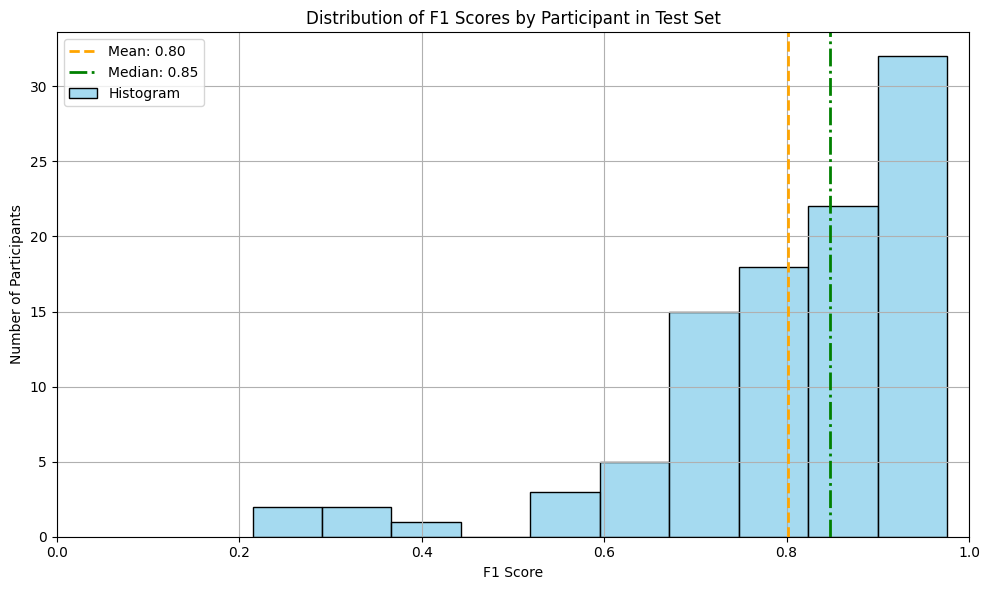

In [22]:
def plot_f1_distribution_by_participant(rf_model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the distribution of F1 scores for each participant in test_df using the trained rf_model.
    Adds mean and median F1 score lines. Removes density plot and limits x-axis to 0-1.
    """
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    participant_ids = test_df[id_col].unique()
    f1_scores = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        y_true = user_df[outcome_col]
        if len(y_true.unique()) < 2:
            f1 = float('nan')  # F1 undefined if only one class
        else:
            X = user_df[feature_cols]
            y_pred = rf_model.predict(X)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append({'participant_id': pid, 'f1_score': f1})
    f1_df = pd.DataFrame(f1_scores)

    mean_f1 = f1_df['f1_score'].mean()
    median_f1 = f1_df['f1_score'].median()

    plt.figure(figsize=(10, 6))
    # Histogram only, no density
    sns.histplot(f1_df['f1_score'].dropna(), bins=10, kde=False, color='skyblue', label='Histogram')

    # Mean and median lines
    plt.axvline(mean_f1, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.2f}')
    plt.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_f1:.2f}')

    plt.xlabel('F1 Score')
    plt.ylabel('Number of Participants')
    plt.title('Distribution of F1 Scores by Participant in Test Set')
    plt.xlim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return f1_df

# Example usage:
f1_df = plot_f1_distribution_by_participant(rf_model, test_df)

In [23]:
def save_f1_scores_by_participant(rf_model, test_df, output_path, outcome_col='outcome', id_col='participant_id'):
    """
    Computes the F1 score for each participant in test_df using the trained rf_model and saves as a CSV.
    Returns the DataFrame of F1 scores.
    """
    from sklearn.metrics import f1_score
    import pandas as pd

    participant_ids = test_df[id_col].unique()
    f1_scores = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        y_true = user_df[outcome_col]
        if len(y_true.unique()) < 2:
            f1 = float('nan')  # F1 undefined if only one class
        else:
            X = user_df[feature_cols]
            y_pred = rf_model.predict(X)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append({'participant_id': pid, 'f1_score': f1})
    f1_df = pd.DataFrame(f1_scores)
    f1_df.to_csv(output_path, index=False)
    print(f'F1 scores by participant saved to {output_path}')
    return f1_df

# Example usage:
f1_df = save_f1_scores_by_participant(
    rf_model,
    test_df,
    '/Users/adityaponnada/Downloads/time_study_data/f1_scores_by_participant.csv'
)

# Example usage:
# f1_df = save_f1_scores_by_participant(rf_model, test_df, 'f1_scores_by_participant.csv')

F1 scores by participant saved to /Users/adityaponnada/Downloads/time_study_data/f1_scores_by_participant.csv


# With XGBoost

In [33]:
def train_and_evaluate_xgboost(train_df, id_col='participant_id', outcome_col='outcome', random_state=42):
    """
    Train an XGBoost classifier on `train_df` and return the fitted model.

    Contract:
    - Inputs:
      - train_df: pandas DataFrame containing training rows (must include outcome_col)
      - id_col: participant id column to exclude from features
      - outcome_col: name of binary outcome column (0/1)
      - random_state: RNG seed
    - Output: fitted XGBClassifier instance

    Notes:
    - Lazy-imports xgboost and raises informative ImportError if unavailable.
    - Computes scale_pos_weight from training labels to help with imbalance.
    - Aligns and uses all columns except id_col and outcome_col as features.
    """
    # local import to avoid requiring xgboost at import time
    try:
        from xgboost import XGBClassifier
    except Exception as e:
        raise ImportError("xgboost is required to run train_and_evaluate_xgboost. Install with `pip install xgboost`.") from e

    import numpy as np

    feature_cols = [c for c in train_df.columns if c not in [id_col, outcome_col]]
    X_train = train_df[feature_cols]
    y_train = train_df[outcome_col]

    # compute scale_pos_weight from training labels to help with imbalance
    y_vals = np.array(y_train)
    n_pos = int((y_vals == 1).sum())
    n_neg = int((y_vals == 0).sum())
    if n_pos > 0 and n_neg > 0:
        scale_pos_weight = float(n_neg) / float(n_pos)
    else:
        scale_pos_weight = 1.0

    clf = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        scale_pos_weight=scale_pos_weight,
        verbosity=0,
    )

    clf.fit(X_train, y_train)

    return clf

# Example usage:
xgb_model = train_and_evaluate_xgboost(train_df)
# Note: This function only returns the trained model; use evaluate_classifier_on_test or a separate helper to evaluate on `test_df`.


In [34]:
def evaluate_xgboost_on_test(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluate a fitted XGBoost (or sklearn-like) model on test_df.

    Returns a dict with keys: accuracy, precision, recall, f1, auc
    - auc will be None if probability scores are unavailable or if AUC cannot be computed.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    import numpy as np

    feature_cols = [c for c in test_df.columns if c not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]

    # Predictions
    y_pred = model.predict(X_test)

    # Try to get probability / score for AUC
    y_score = None
    if hasattr(model, 'predict_proba'):
        try:
            y_score = model.predict_proba(X_test)[:, 1]
        except Exception:
            y_score = None
    elif hasattr(model, 'decision_function'):
        try:
            y_score = model.decision_function(X_test)
        except Exception:
            y_score = None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    auc = None
    if y_score is not None:
        try:
            # Only compute AUC when both classes present in y_test
            if len(np.unique(y_test)) == 2:
                auc = roc_auc_score(y_test, y_score)
        except Exception:
            auc = None

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

    # Print a brief summary for interactive use
    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc if auc is not None else 'N/A'}")

    return metrics

# Example usage:
metrics = evaluate_xgboost_on_test(xgb_model, test_df)
# print(metrics)


Accuracy: 0.5356 | Precision: 0.8951 | Recall: 0.4704 | F1: 0.6167 | AUC: 0.7321834775010534


Could not save figure to /path/to/f1_dist.png: [Errno 2] No such file or directory: '/path/to/f1_dist.png'


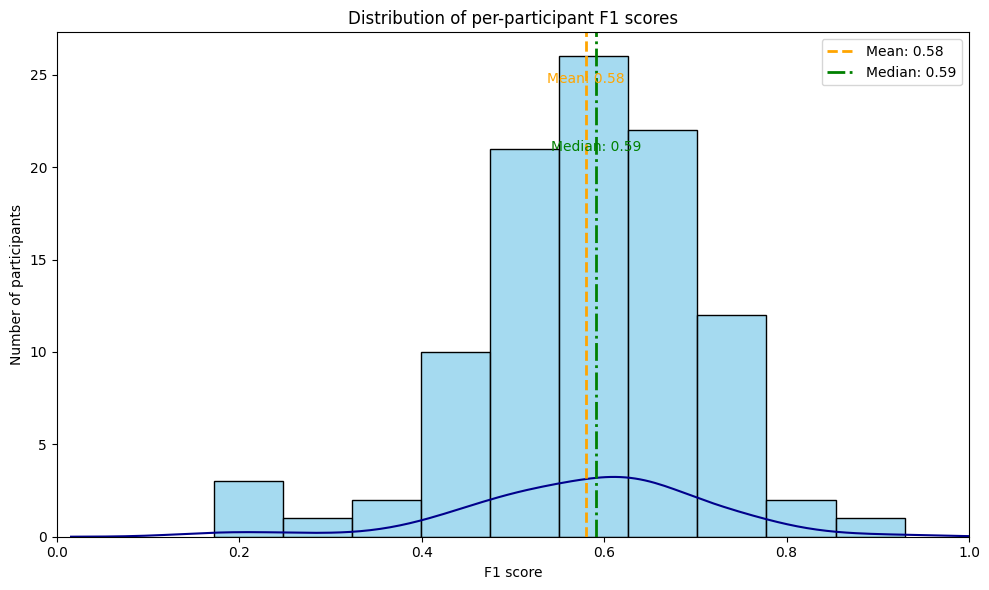

In [36]:
def plot_f1_distribution_for_model(model, test_df, outcome_col='outcome', id_col='participant_id', bins=10, show_kde=False, figsize=(10,6), save_path=None):
    """
    Compute per-participant F1 scores on `test_df` using `model`, plot the distribution,
    and draw vertical lines for mean and median.

    Returns the DataFrame with columns: ['participant_id', 'f1_score']

    Parameters:
    - model: fitted classifier with a .predict method
    - test_df: DataFrame containing test rows with outcome and participant id
    - outcome_col, id_col: column names (defaults: 'outcome', 'participant_id')
    - bins: number of histogram bins
    - show_kde: whether to overlay a KDE on the histogram
    - figsize: tuple for figure size
    - save_path: optional path to save the figure (PNG)
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import f1_score
    import numpy as np

    participant_ids = test_df[id_col].unique()
    records = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        y_true = user_df[outcome_col]
        feature_cols = [c for c in user_df.columns if c not in [outcome_col, id_col]]
        if len(y_true.unique()) < 2:
            f1 = float('nan')
        else:
            X = user_df[feature_cols]
            y_pred = model.predict(X)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        records.append({'participant_id': pid, 'f1_score': f1})

    f1_df = pd.DataFrame.from_records(records)

    mean_f1 = f1_df['f1_score'].mean()
    median_f1 = f1_df['f1_score'].median()

    plt.figure(figsize=figsize)
    ax = sns.histplot(f1_df['f1_score'].dropna(), bins=bins, kde=False, color='skyblue')
    if show_kde:
        try:
            sns.kdeplot(f1_df['f1_score'].dropna(), ax=ax, color='darkblue')
        except Exception:
            pass

    # Draw mean and median lines
    ax.axvline(mean_f1, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.2f}')
    ax.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_f1:.2f}')

    # Place small text annotations near the top of the plot
    ymin, ymax = ax.get_ylim()
    y_text = ymax * 0.9
    ax.text(mean_f1, y_text, f'Mean: {mean_f1:.2f}', color='orange', ha='center')
    ax.text(median_f1, y_text * 0.85, f'Median: {median_f1:.2f}', color='green', ha='center')

    ax.set_xlim(0, 1)
    ax.set_xlabel('F1 score')
    ax.set_ylabel('Number of participants')
    ax.set_title('Distribution of per-participant F1 scores')
    ax.legend()
    plt.tight_layout()

    if save_path:
        try:
            plt.savefig(save_path, dpi=150)
            print(f'Figure saved to {save_path}')
        except Exception as e:
            print(f'Could not save figure to {save_path}: {e}')

    plt.show()
    return f1_df

# Example usage:
f1_df = plot_f1_distribution_for_model(xgb_model, test_df, show_kde=True, save_path='/path/to/f1_dist.png')


In [37]:
def export_f1_scores_for_model(model, test_df, output_path=None, outcome_col='outcome', id_col='participant_id'):
    """
    Compute per-participant F1 scores using `model` on `test_df` and save to CSV.

    Defaults to saving in the same folder used earlier for RF f1 scores.
    Returns the DataFrame of per-participant f1 scores and the path written.
    """
    import pandas as pd
    from sklearn.metrics import f1_score
    import os

    # Default output path (same folder as RF f1 scores used elsewhere)
    if output_path is None:
        output_path = '/Users/adityaponnada/Downloads/time_study_data/f1_scores_by_participant_xgb.csv'

    participant_ids = test_df[id_col].unique()
    records = []
    for pid in participant_ids:
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        y_true = user_df[outcome_col]
        feature_cols = [c for c in user_df.columns if c not in [outcome_col, id_col]]
        if len(y_true.unique()) < 2:
            f1 = float('nan')
        else:
            X = user_df[feature_cols]
            y_pred = model.predict(X)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        records.append({'participant_id': pid, 'f1_score': f1})

    f1_df = pd.DataFrame.from_records(records)

    # Ensure directory exists
    out_dir = os.path.dirname(output_path)
    try:
        os.makedirs(out_dir, exist_ok=True)
    except Exception:
        pass

    f1_df.to_csv(output_path, index=False)
    print(f'Per-participant F1 scores saved to {output_path}')
    return f1_df, output_path

# Example usage:
f1_df, path = export_f1_scores_for_model(xgb_model, test_df)


Per-participant F1 scores saved to /Users/adityaponnada/Downloads/time_study_data/f1_scores_by_participant_xgb.csv


In [38]:
import pickle

# Save the trained XGBoost model (xgb_model) to the specified folder (same pattern as RF)
model_save_path = '/Users/adityaponnada/Downloads/time_study_data/trained_models/xgb_model_trained_ws.pkl'
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(xgb_model, f)
    print(f"XGBoost model saved as {model_save_path}")
except NameError:
    print('Variable `xgb_model` not found. Make sure you run the training cell that creates `xgb_model` before running this cell.')
except Exception as e:
    print(f'Failed to save XGBoost model to {model_save_path}: {e}')


XGBoost model saved as /Users/adityaponnada/Downloads/time_study_data/trained_models/xgb_model_trained_ws.pkl
